In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.applications as apps
from numpy.random import seed
from tensorflow.random import set_seed

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

seed(42)
set_seed(42)

2023-06-23 13:37:13.451701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 13:37:13.548418: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2023-06-23 13:37:13.548432: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-23 13:37:14.068049: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object

# Análise de Imagens em GrayScale

## Extração do Dataset em GrayScale

In [2]:
def GrayScale(image):
    return cv.cvtColor(cv.cvtColor(image, cv.COLOR_RGB2GRAY), cv.COLOR_GRAY2RGB)

In [3]:
from sklearn.model_selection import train_test_split
import cv2 as cv
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
# Extrair imagens da pasta

X_data = []
y_data = []
cont = 0
for letra in os.listdir('/media/emanueloliveira/Dados/SCC0910ComputerVision/NossoDatasetAug/'):
    for image in load_images_from_folder(f'/media/emanueloliveira/Dados/SCC0910ComputerVision/NossoDatasetAug/{letra}'):
        X_data.append(GrayScale(image))
        y_data.append(cont)
    cont += 1

In [5]:
cont = 0
for image in np.asarray(X_data):
    X_data[cont] = cv.resize(image, [64, 64])
    cont += 1 

X_data = np.asarray(X_data)
y_data = np.asarray(y_data)

In [6]:
X_data = np.array(X_data)
y_data = np.array(y_data)

print(X_data.shape)
print(y_data.shape)

(1505, 64, 64, 3)
(1505,)


In [7]:
# Dados de Treino, Validação e Teste

X_image_train, X_image_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1)
X_image_train, X_image_val, y_train, y_val = train_test_split(X_image_train, y_train, test_size=0.1)

In [8]:
# Binarizar rotolus

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

In [11]:
print(f"original: {lb.inverse_transform(y_train[0:5])}\n")
print(f"binarizado:\n{y_train[0:5]}")

original: [14 17 11  1 17]

binarizado:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]


## Testando com CNN rasa

### Variando Função de Ativação

#### Ativação ReLU

In [12]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                        

2023-06-23 13:38:09.231866: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/emanueloliveira/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2023-06-23 13:38:09.231887: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-23 13:38:09.231903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (emanueloliveira-CI581128TBW10): /proc/driver/nvidia/version does not exist
2023-06-23 13:38:09.232113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations,

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 8s 195ms/step - loss: 5.6172 - categorical_accuracy: 0.0640 - val_loss: 2.9838 - val_categorical_accuracy: 0.0956
Epoch 2/100
39/39 [==============================] - 8s 192ms/step - loss: 2.9160 - categorical_accuracy: 0.1264 - val_loss: 2.7552 - val_categorical_accuracy: 0.2132
Epoch 3/100
39/39 [==============================] - 7s 190ms/step - loss: 2.3509 - categorical_accuracy: 0.3021 - val_loss: 2.2362 - val_categorical_accuracy: 0.4044
Epoch 4/100
39/39 [==============================] - 7s 190ms/step - loss: 1.3423 - categorical_accuracy: 0.6067 - val_loss: 2.0784 - val_categorical_accuracy: 0.4853
Epoch 5/100
39/39 [==============================] - 7s 188ms/step - loss: 0.7158 - categorical_accuracy: 0.8021 - val_loss: 2.6766 - val_categorical_accuracy: 0.5441
Epoch 6/100
39/39 [==============================] - 7s 190ms/step - loss: 0.4603 - categorical_accuracy: 0.8596 - val_loss: 2.3763 - val_categorical_accuracy: 0.580

Best Validation Loss: 2.0784
Best Validation Accuracy: 63.2353%


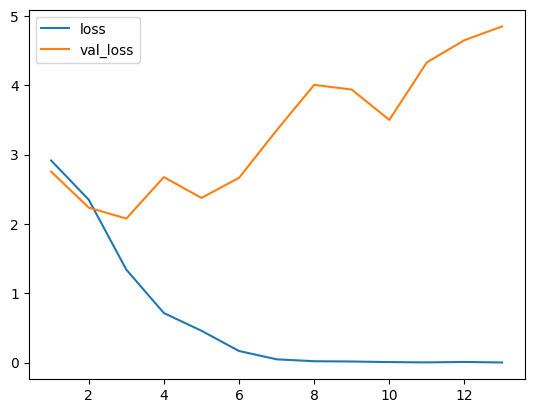

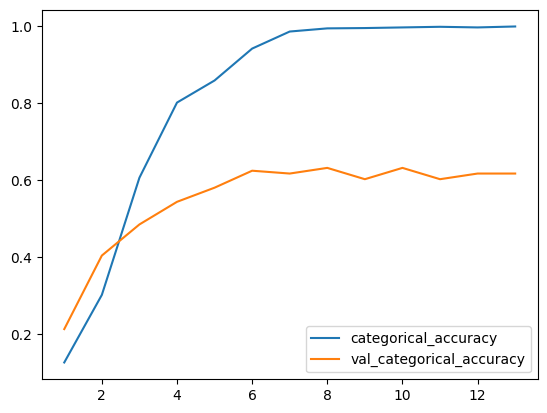

In [14]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [15]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 34ms/step - loss: 1.8268 - categorical_accuracy: 0.5695
Acurácia em dados de teste: 56.9536%


#### Ativação LeakyReLU

In [16]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same',  input_shape=(64, 64, 3)),
    layers.LeakyReLU(),
    layers.Conv2D(64, kernel_size=(3,3), padding='same'),
    layers.LeakyReLU(),
    layers.Conv2D(64, kernel_size=(3,3), padding='same'),
    layers.LeakyReLU(),
    layers.Conv2D(64, kernel_size=(3,3), padding='same'),
    layers.LeakyReLU(),
    layers.Conv2D(64, kernel_size=(3,3), padding='same'),
    layers.LeakyReLU(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)       

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 8s 201ms/step - loss: 16.6864 - categorical_accuracy: 0.0542 - val_loss: 4.5722 - val_categorical_accuracy: 0.0662
Epoch 2/100
39/39 [==============================] - 8s 199ms/step - loss: 3.2098 - categorical_accuracy: 0.1322 - val_loss: 3.6887 - val_categorical_accuracy: 0.0735
Epoch 3/100
39/39 [==============================] - 8s 197ms/step - loss: 2.5369 - categorical_accuracy: 0.2709 - val_loss: 2.7150 - val_categorical_accuracy: 0.2721
Epoch 4/100
39/39 [==============================] - 8s 197ms/step - loss: 1.8819 - categorical_accuracy: 0.4713 - val_loss: 2.3496 - val_categorical_accuracy: 0.3382
Epoch 5/100
39/39 [==============================] - 8s 200ms/step - loss: 1.4310 - categorical_accuracy: 0.5952 - val_loss: 2.4734 - val_categorical_accuracy: 0.4044
Epoch 6/100
39/39 [==============================] - 8s 194ms/step - loss: 1.0350 - categorical_accuracy: 0.7159 - val_loss: 2.0047 - val_categorical_accuracy: 0.53

Best Validation Loss: 1.7933
Best Validation Accuracy: 63.2353%


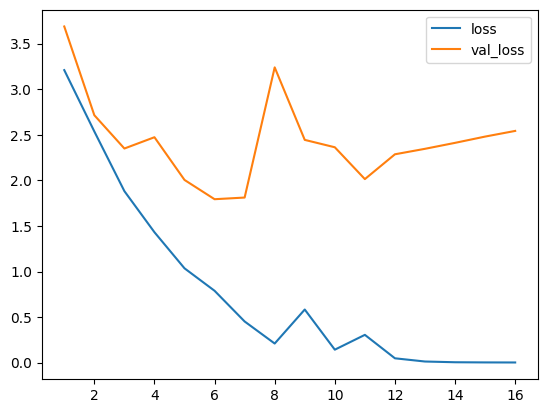

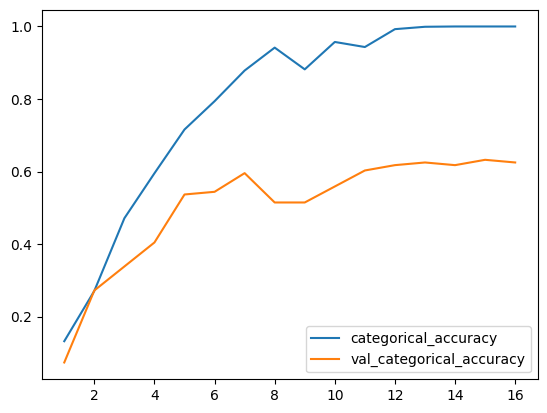

In [18]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [20]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 31ms/step - loss: 1.9920 - categorical_accuracy: 0.5497
Acurácia em dados de teste: 54.9669%


#### Ativação ELU

In [21]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same', activation="elu",  input_shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="elu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="elu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="elu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="elu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                      

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 8s 198ms/step - loss: 10.1083 - categorical_accuracy: 0.0608 - val_loss: 7.5647 - val_categorical_accuracy: 0.0662
Epoch 2/100
39/39 [==============================] - 8s 195ms/step - loss: 4.6549 - categorical_accuracy: 0.0977 - val_loss: 3.9175 - val_categorical_accuracy: 0.1250
Epoch 3/100
39/39 [==============================] - 8s 203ms/step - loss: 3.0902 - categorical_accuracy: 0.1987 - val_loss: 5.1324 - val_categorical_accuracy: 0.0441
Epoch 4/100
39/39 [==============================] - 8s 194ms/step - loss: 2.6795 - categorical_accuracy: 0.3186 - val_loss: 3.1356 - val_categorical_accuracy: 0.2426
Epoch 5/100
39/39 [==============================] - 8s 198ms/step - loss: 1.7558 - categorical_accuracy: 0.5197 - val_loss: 3.7268 - val_categorical_accuracy: 0.2574
Epoch 6/100
39/39 [==============================] - 9s 235ms/step - loss: 1.2040 - categorical_accuracy: 0.6527 - val_loss: 2.1239 - val_categorical_accuracy: 0.51

Best Validation Loss: 2.0169
Best Validation Accuracy: 57.3529%


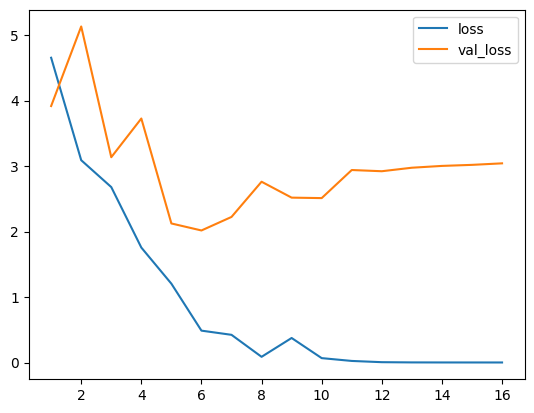

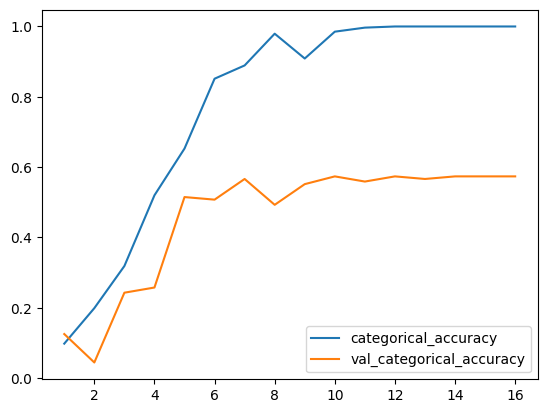

In [23]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [24]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 38ms/step - loss: 2.4252 - categorical_accuracy: 0.5364
Acurácia em dados de teste: 53.6424%


## Melhor Ativação: ReLU (56.9536%)

### Variando quantidade de camadas Convolucionais

#### 1 Camada

In [25]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 16384)             0         
                                                                 
 dense_3 (Dense)             (None, 20)                327700    
                                                                 
Total params: 329,492
Trainable params: 329,492
Non-trainable params: 0
_________________________________________________________________


In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 1s 14ms/step - loss: 90.5868 - categorical_accuracy: 0.0608 - val_loss: 5.3664 - val_categorical_accuracy: 0.0441
Epoch 2/100
39/39 [==============================] - 1s 14ms/step - loss: 3.4025 - categorical_accuracy: 0.1954 - val_loss: 3.8140 - val_categorical_accuracy: 0.1397
Epoch 3/100
39/39 [==============================] - 0s 13ms/step - loss: 1.9975 - categorical_accuracy: 0.4450 - val_loss: 3.6674 - val_categorical_accuracy: 0.2206
Epoch 4/100
39/39 [==============================] - 1s 13ms/step - loss: 1.4092 - categorical_accuracy: 0.6256 - val_loss: 3.7768 - val_categorical_accuracy: 0.3971
Epoch 5/100
39/39 [==============================] - 0s 13ms/step - loss: 1.0568 - categorical_accuracy: 0.7167 - val_loss: 4.5018 - val_categorical_accuracy: 0.4044
Epoch 6/100
39/39 [==============================] - 1s 13ms/step - loss: 1.1232 - categorical_accuracy: 0.7422 - val_loss: 4.1190 - val_categorical_accuracy: 0.4118
Epo

Best Validation Loss: 3.6674
Best Validation Accuracy: 44.1176%


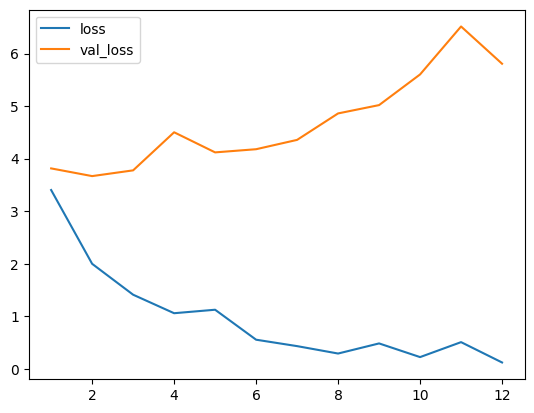

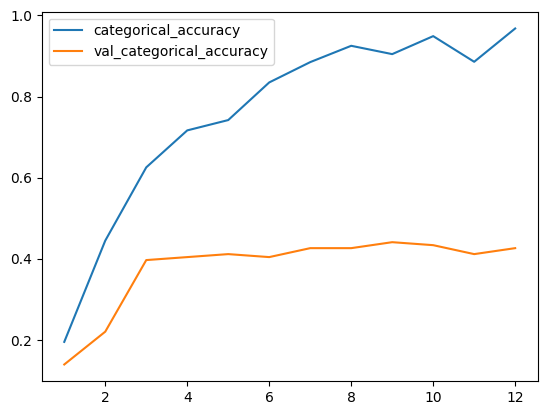

In [27]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [28]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 4ms/step - loss: 3.1546 - categorical_accuracy: 0.3311
Acurácia em dados de teste: 33.1126%


#### 3 Camadas

In [29]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 16384)             0         
                                                                 
 dense_4 (Dense)             (None, 20)                327700    
                                                      

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 5s 103ms/step - loss: 8.9171 - categorical_accuracy: 0.0616 - val_loss: 2.9389 - val_categorical_accuracy: 0.1544
Epoch 2/100
39/39 [==============================] - 4s 101ms/step - loss: 2.7378 - categorical_accuracy: 0.2110 - val_loss: 2.6190 - val_categorical_accuracy: 0.2279
Epoch 3/100
39/39 [==============================] - 4s 101ms/step - loss: 2.0526 - categorical_accuracy: 0.4253 - val_loss: 2.4836 - val_categorical_accuracy: 0.3456
Epoch 4/100
39/39 [==============================] - 4s 104ms/step - loss: 1.4479 - categorical_accuracy: 0.5993 - val_loss: 2.4502 - val_categorical_accuracy: 0.4338
Epoch 5/100
39/39 [==============================] - 4s 101ms/step - loss: 1.0096 - categorical_accuracy: 0.7159 - val_loss: 2.1977 - val_categorical_accuracy: 0.4926
Epoch 6/100
39/39 [==============================] - 4s 101ms/step - loss: 0.6516 - categorical_accuracy: 0.8202 - val_loss: 2.3378 - val_categorical_accuracy: 0.514

Best Validation Loss: 2.1977
Best Validation Accuracy: 60.2941%


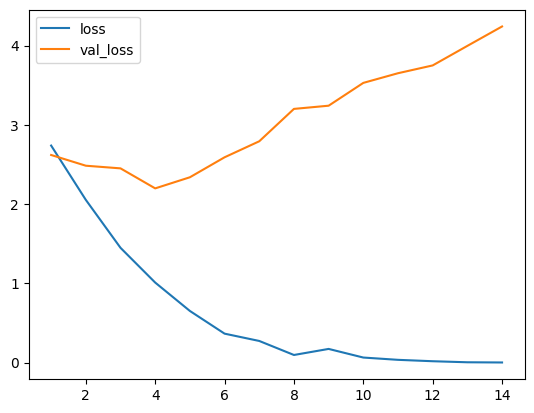

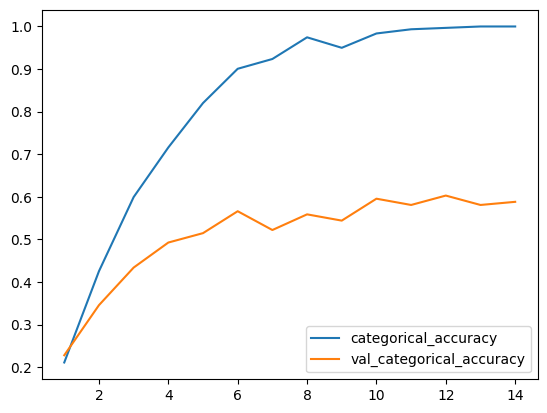

In [31]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [32]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 21ms/step - loss: 2.3664 - categorical_accuracy: 0.5166
Acurácia em dados de teste: 51.6556%


#### 6 Camadas

In [33]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)      

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 10s 231ms/step - loss: 4.4272 - categorical_accuracy: 0.0575 - val_loss: 2.9281 - val_categorical_accuracy: 0.1324
Epoch 2/100
39/39 [==============================] - 9s 228ms/step - loss: 2.8404 - categorical_accuracy: 0.1486 - val_loss: 2.7464 - val_categorical_accuracy: 0.1912
Epoch 3/100
39/39 [==============================] - 9s 233ms/step - loss: 2.4129 - categorical_accuracy: 0.2742 - val_loss: 2.3910 - val_categorical_accuracy: 0.3603
Epoch 4/100
39/39 [==============================] - 9s 238ms/step - loss: 1.8930 - categorical_accuracy: 0.4631 - val_loss: 2.2870 - val_categorical_accuracy: 0.3603
Epoch 5/100
39/39 [==============================] - 10s 244ms/step - loss: 1.3576 - categorical_accuracy: 0.5985 - val_loss: 1.8908 - val_categorical_accuracy: 0.5147
Epoch 6/100
39/39 [==============================] - 9s 234ms/step - loss: 0.8869 - categorical_accuracy: 0.7430 - val_loss: 1.9702 - val_categorical_accuracy: 0.5

Best Validation Loss: 1.8908
Best Validation Accuracy: 59.5588%


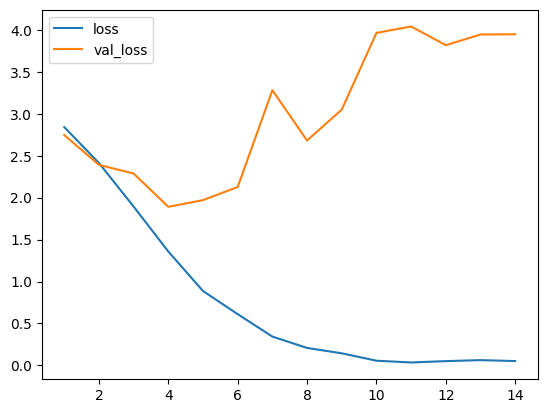

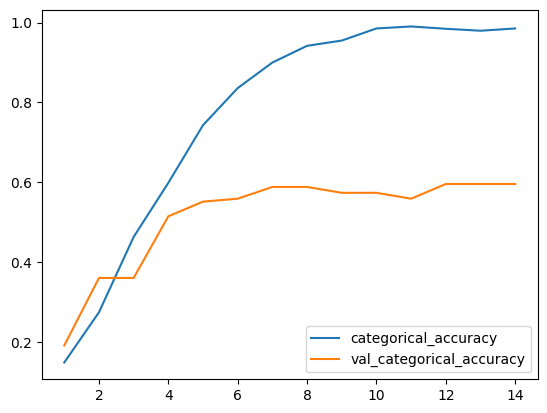

In [35]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [36]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 40ms/step - loss: 1.9693 - categorical_accuracy: 0.5364
Acurácia em dados de teste: 53.6424%


### Resultados:
    1 Camada: 33.1126%
    3 Camadas: 51.6556%
    5 Camadas: 56.9536%
    6 Camadas: 53.6424%

## Escolha: 5 Camadas (56.9536%)

### Variando Quantidade de Filtros

#### 32 Filtros

In [41]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(32, kernel_size=(3,3), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(32, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(32, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(32, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(32, kernel_size=(3,3), padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 4s 81ms/step - loss: 5.0850 - categorical_accuracy: 0.0550 - val_loss: 3.0044 - val_categorical_accuracy: 0.0441
Epoch 2/100
39/39 [==============================] - 3s 76ms/step - loss: 2.9505 - categorical_accuracy: 0.0928 - val_loss: 2.9577 - val_categorical_accuracy: 0.1176
Epoch 3/100
39/39 [==============================] - 3s 75ms/step - loss: 2.7159 - categorical_accuracy: 0.2102 - val_loss: 2.5090 - val_categorical_accuracy: 0.2721
Epoch 4/100
39/39 [==============================] - 3s 76ms/step - loss: 1.8106 - categorical_accuracy: 0.4819 - val_loss: 2.8266 - val_categorical_accuracy: 0.3235
Epoch 5/100
39/39 [==============================] - 3s 77ms/step - loss: 1.1917 - categorical_accuracy: 0.6585 - val_loss: 1.9850 - val_categorical_accuracy: 0.4632
Epoch 6/100
39/39 [==============================] - 3s 76ms/step - loss: 0.7263 - categorical_accuracy: 0.7956 - val_loss: 2.1796 - val_categorical_accuracy: 0.5221
Epoc

Best Validation Loss: 1.9850
Best Validation Accuracy: 57.3529%


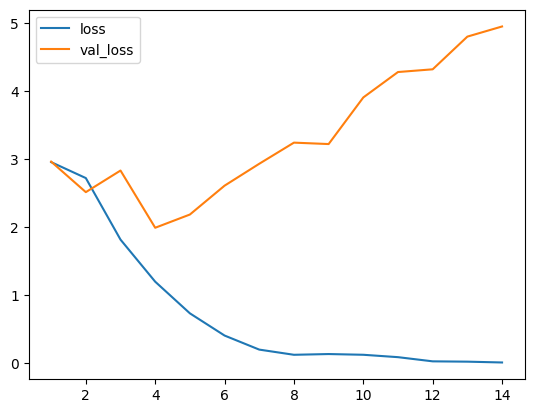

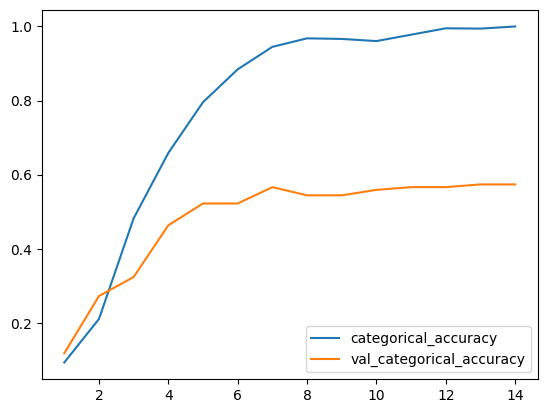

In [43]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [44]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 14ms/step - loss: 2.1268 - categorical_accuracy: 0.5232
Acurácia em dados de teste: 52.3179%


#### 48 Filtros

In [45]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(48, kernel_size=(3,3), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(48, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(48, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(48, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(48, kernel_size=(3,3), padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 32, 32, 48)        1344      
                                                                 
 conv2d_36 (Conv2D)          (None, 32, 32, 48)        20784     
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 48)        20784     
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 48)        20784     
                                                                 
 conv2d_39 (Conv2D)          (None, 32, 32, 48)        20784     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 48)       0         
 2D)                                                             
                                                      

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 6s 135ms/step - loss: 8.4237 - categorical_accuracy: 0.0525 - val_loss: 2.9737 - val_categorical_accuracy: 0.1029
Epoch 2/100
39/39 [==============================] - 5s 133ms/step - loss: 2.9457 - categorical_accuracy: 0.1034 - val_loss: 2.9062 - val_categorical_accuracy: 0.1250
Epoch 3/100
39/39 [==============================] - 5s 133ms/step - loss: 2.5674 - categorical_accuracy: 0.2447 - val_loss: 2.3826 - val_categorical_accuracy: 0.3750
Epoch 4/100
39/39 [==============================] - 5s 133ms/step - loss: 1.7707 - categorical_accuracy: 0.4869 - val_loss: 1.9196 - val_categorical_accuracy: 0.5147
Epoch 5/100
39/39 [==============================] - 5s 132ms/step - loss: 1.0778 - categorical_accuracy: 0.6814 - val_loss: 1.8250 - val_categorical_accuracy: 0.5956
Epoch 6/100
39/39 [==============================] - 5s 136ms/step - loss: 0.6078 - categorical_accuracy: 0.8186 - val_loss: 1.9117 - val_categorical_accuracy: 0.573

Best Validation Loss: 1.8250
Best Validation Accuracy: 62.5000%


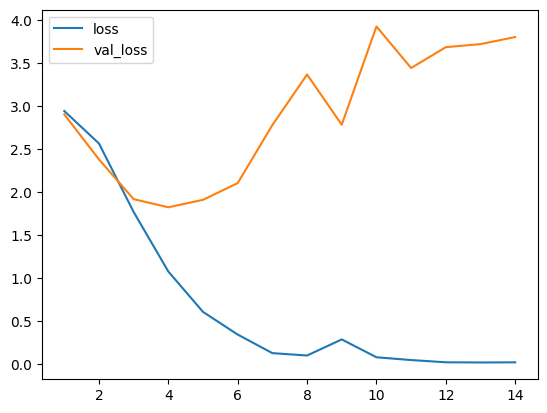

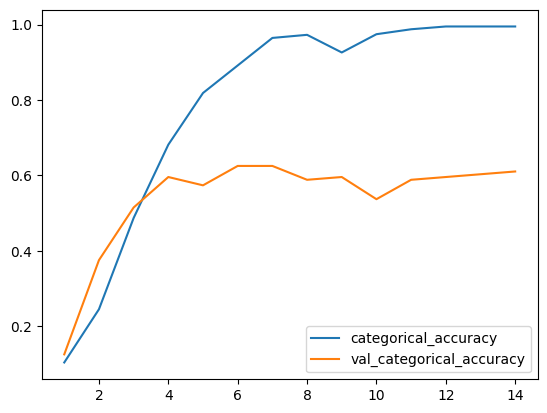

In [47]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [48]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 23ms/step - loss: 1.8996 - categorical_accuracy: 0.5166
Acurácia em dados de teste: 51.6556%


#### 80 Filtros

In [49]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(80, kernel_size=(3,3), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(80, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(80, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(80, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(80, kernel_size=(3,3), padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 32, 32, 80)        2240      
                                                                 
 conv2d_41 (Conv2D)          (None, 32, 32, 80)        57680     
                                                                 
 conv2d_42 (Conv2D)          (None, 32, 32, 80)        57680     
                                                                 
 conv2d_43 (Conv2D)          (None, 32, 32, 80)        57680     
                                                                 
 conv2d_44 (Conv2D)          (None, 32, 32, 80)        57680     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 80)       0         
 2D)                                                             
                                                      

In [50]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 11s 257ms/step - loss: 7.3863 - categorical_accuracy: 0.0452 - val_loss: 2.9869 - val_categorical_accuracy: 0.0735
Epoch 2/100
39/39 [==============================] - 10s 251ms/step - loss: 2.9375 - categorical_accuracy: 0.1067 - val_loss: 2.9303 - val_categorical_accuracy: 0.1691
Epoch 3/100
39/39 [==============================] - 10s 251ms/step - loss: 2.6294 - categorical_accuracy: 0.2250 - val_loss: 2.4017 - val_categorical_accuracy: 0.3382
Epoch 4/100
39/39 [==============================] - 10s 253ms/step - loss: 1.8829 - categorical_accuracy: 0.4704 - val_loss: 1.9797 - val_categorical_accuracy: 0.4338
Epoch 5/100
39/39 [==============================] - 10s 251ms/step - loss: 1.1662 - categorical_accuracy: 0.6691 - val_loss: 2.2043 - val_categorical_accuracy: 0.5368
Epoch 6/100
39/39 [==============================] - 10s 251ms/step - loss: 0.7515 - categorical_accuracy: 0.7783 - val_loss: 2.1997 - val_categorical_accuracy:

Best Validation Loss: 1.9797
Best Validation Accuracy: 55.8824%


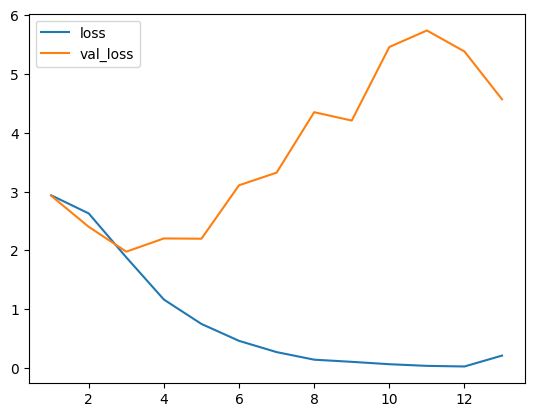

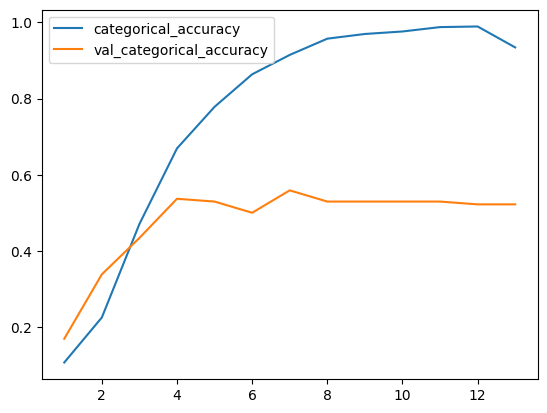

In [51]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [52]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 46ms/step - loss: 2.0312 - categorical_accuracy: 0.4172
Acurácia em dados de teste: 41.7219%


## Quantidade de Filtors: 64 Filtros (56.9536%)

### Variando Kernel Size

#### Kernel 2x2

In [53]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(64, kernel_size=(2,2), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=(2,2), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(2,2), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(2,2), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(2,2), padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 32, 32, 64)        832       
                                                                 
 conv2d_46 (Conv2D)          (None, 32, 32, 64)        16448     
                                                                 
 conv2d_47 (Conv2D)          (None, 32, 32, 64)        16448     
                                                                 
 conv2d_48 (Conv2D)          (None, 32, 32, 64)        16448     
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 64)        16448     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                     

In [54]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 4s 97ms/step - loss: 6.2865 - categorical_accuracy: 0.0624 - val_loss: 2.9842 - val_categorical_accuracy: 0.0515
Epoch 2/100
39/39 [==============================] - 4s 99ms/step - loss: 2.7914 - categorical_accuracy: 0.1773 - val_loss: 2.6426 - val_categorical_accuracy: 0.2574
Epoch 3/100
39/39 [==============================] - 4s 93ms/step - loss: 2.0706 - categorical_accuracy: 0.3966 - val_loss: 2.0386 - val_categorical_accuracy: 0.3971
Epoch 4/100
39/39 [==============================] - 4s 91ms/step - loss: 1.3445 - categorical_accuracy: 0.6141 - val_loss: 2.0114 - val_categorical_accuracy: 0.5074
Epoch 5/100
39/39 [==============================] - 4s 92ms/step - loss: 0.8301 - categorical_accuracy: 0.7603 - val_loss: 1.9082 - val_categorical_accuracy: 0.5221
Epoch 6/100
39/39 [==============================] - 4s 92ms/step - loss: 0.4989 - categorical_accuracy: 0.8596 - val_loss: 2.4114 - val_categorical_accuracy: 0.5074
Epoc

Best Validation Loss: 1.9082
Best Validation Accuracy: 58.0882%


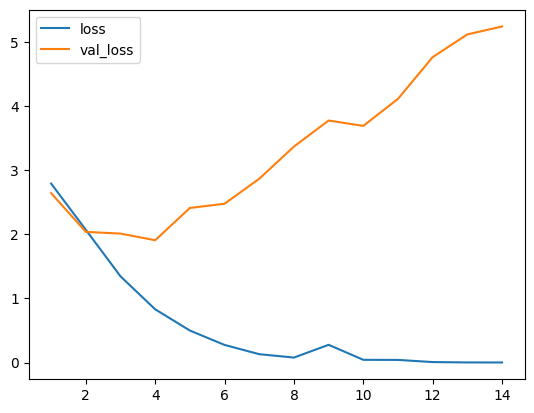

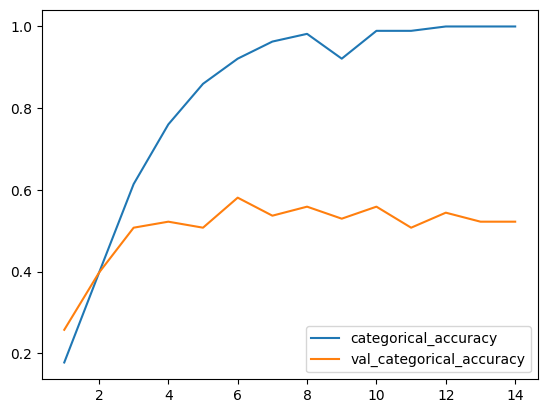

In [55]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [56]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 19ms/step - loss: 2.0798 - categorical_accuracy: 0.5497
Acurácia em dados de teste: 54.9669%


#### Kernel 4x4

In [57]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(64, kernel_size=(4,4), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=(4,4), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(4,4), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(4,4), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(4,4), padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 32, 32, 64)        3136      
                                                                 
 conv2d_51 (Conv2D)          (None, 32, 32, 64)        65600     
                                                                 
 conv2d_52 (Conv2D)          (None, 32, 32, 64)        65600     
                                                                 
 conv2d_53 (Conv2D)          (None, 32, 32, 64)        65600     
                                                                 
 conv2d_54 (Conv2D)          (None, 32, 32, 64)        65600     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                     

In [58]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 13s 327ms/step - loss: 4.0899 - categorical_accuracy: 0.0435 - val_loss: 2.9772 - val_categorical_accuracy: 0.0368
Epoch 2/100
39/39 [==============================] - 12s 313ms/step - loss: 2.9820 - categorical_accuracy: 0.0616 - val_loss: 2.9848 - val_categorical_accuracy: 0.0368
Epoch 3/100
39/39 [==============================] - 12s 314ms/step - loss: 2.9739 - categorical_accuracy: 0.0780 - val_loss: 2.9652 - val_categorical_accuracy: 0.0882
Epoch 4/100
39/39 [==============================] - 12s 314ms/step - loss: 2.9235 - categorical_accuracy: 0.1100 - val_loss: 5.1770 - val_categorical_accuracy: 0.1029
Epoch 5/100
39/39 [==============================] - 12s 315ms/step - loss: 2.9107 - categorical_accuracy: 0.1281 - val_loss: 2.9815 - val_categorical_accuracy: 0.1324
Epoch 6/100
39/39 [==============================] - 12s 318ms/step - loss: 2.6498 - categorical_accuracy: 0.2200 - val_loss: 2.5713 - val_categorical_accuracy:

Best Validation Loss: 2.4551
Best Validation Accuracy: 55.1471%


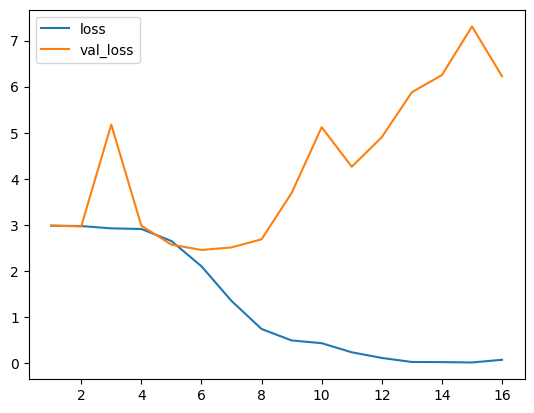

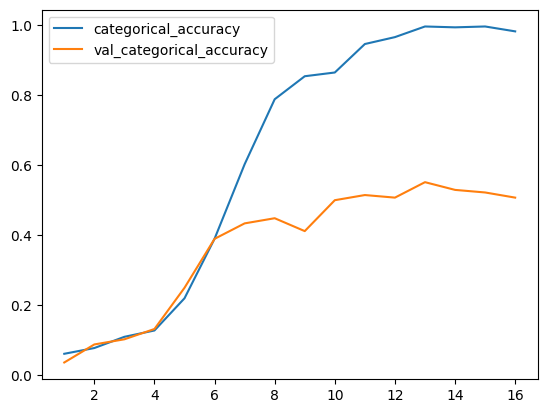

In [59]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [60]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 52ms/step - loss: 2.5702 - categorical_accuracy: 0.3377
Acurácia em dados de teste: 33.7748%


## Kernel: Manter 3x3 (56.9536%)

### Adicionando Dropout Após Flatten

#### Dropout 10%

In [61]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_56 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_57 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_58 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                     

In [62]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 8s 194ms/step - loss: 6.1358 - categorical_accuracy: 0.0624 - val_loss: 2.9938 - val_categorical_accuracy: 0.0882
Epoch 2/100
39/39 [==============================] - 7s 191ms/step - loss: 2.9858 - categorical_accuracy: 0.0690 - val_loss: 2.9733 - val_categorical_accuracy: 0.0368
Epoch 3/100
39/39 [==============================] - 7s 187ms/step - loss: 2.9182 - categorical_accuracy: 0.1125 - val_loss: 2.8289 - val_categorical_accuracy: 0.1765
Epoch 4/100
39/39 [==============================] - 7s 187ms/step - loss: 2.6715 - categorical_accuracy: 0.2143 - val_loss: 2.6713 - val_categorical_accuracy: 0.2132
Epoch 5/100
39/39 [==============================] - 7s 188ms/step - loss: 2.1339 - categorical_accuracy: 0.3662 - val_loss: 2.2610 - val_categorical_accuracy: 0.3824
Epoch 6/100
39/39 [==============================] - 7s 187ms/step - loss: 1.5822 - categorical_accuracy: 0.5452 - val_loss: 2.3008 - val_categorical_accuracy: 0.470

Best Validation Loss: 2.2610
Best Validation Accuracy: 55.1471%


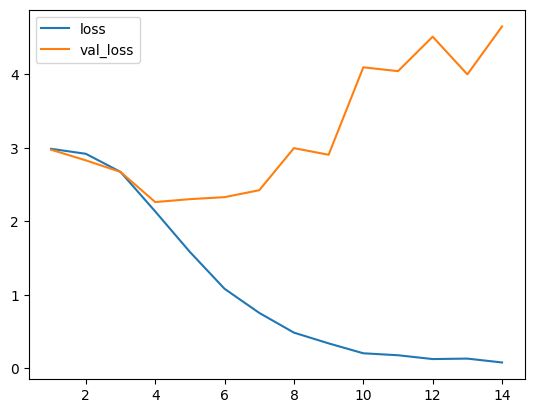

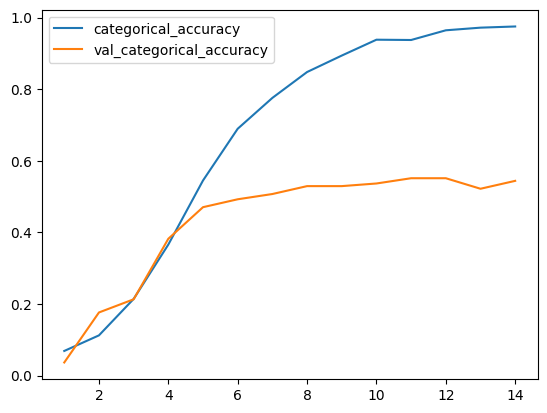

In [63]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [64]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 29ms/step - loss: 2.5306 - categorical_accuracy: 0.3311
Acurácia em dados de teste: 33.1126%


#### Dropout 20%

In [65]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_61 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_62 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_63 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_64 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                     

In [66]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 8s 191ms/step - loss: 5.2543 - categorical_accuracy: 0.0575 - val_loss: 2.9855 - val_categorical_accuracy: 0.0588
Epoch 2/100
39/39 [==============================] - 8s 199ms/step - loss: 2.9797 - categorical_accuracy: 0.0640 - val_loss: 2.9758 - val_categorical_accuracy: 0.0441
Epoch 3/100
39/39 [==============================] - 7s 188ms/step - loss: 2.8545 - categorical_accuracy: 0.1478 - val_loss: 2.7909 - val_categorical_accuracy: 0.2059
Epoch 4/100
39/39 [==============================] - 7s 187ms/step - loss: 2.4501 - categorical_accuracy: 0.2800 - val_loss: 2.7150 - val_categorical_accuracy: 0.1765
Epoch 5/100
39/39 [==============================] - 7s 187ms/step - loss: 1.9203 - categorical_accuracy: 0.4433 - val_loss: 2.0484 - val_categorical_accuracy: 0.4485
Epoch 6/100
39/39 [==============================] - 7s 187ms/step - loss: 1.3769 - categorical_accuracy: 0.5977 - val_loss: 2.0035 - val_categorical_accuracy: 0.477

Best Validation Loss: 1.9972
Best Validation Accuracy: 58.8235%


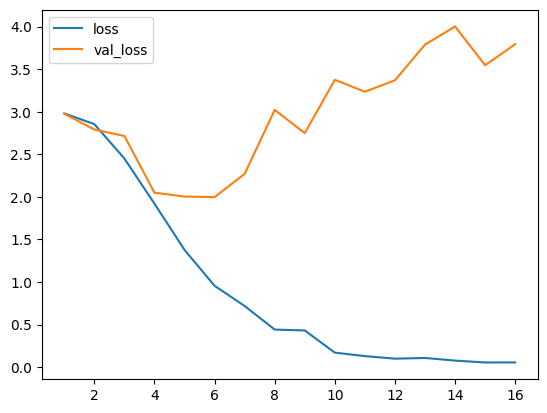

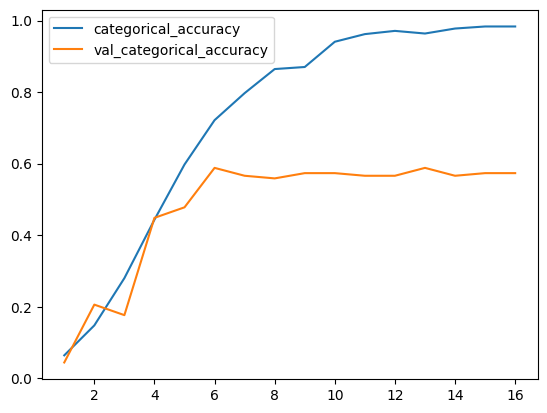

In [67]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [68]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 34ms/step - loss: 2.1597 - categorical_accuracy: 0.5894
Acurácia em dados de teste: 58.9404%


#### Dropout 30%

In [70]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_71 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_72 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_73 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_74 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                     

In [71]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 8s 198ms/step - loss: 5.5328 - categorical_accuracy: 0.0567 - val_loss: 2.9438 - val_categorical_accuracy: 0.1176
Epoch 2/100
39/39 [==============================] - 8s 205ms/step - loss: 2.7399 - categorical_accuracy: 0.1691 - val_loss: 2.4554 - val_categorical_accuracy: 0.3456
Epoch 3/100
39/39 [==============================] - 8s 205ms/step - loss: 2.0490 - categorical_accuracy: 0.4023 - val_loss: 2.0718 - val_categorical_accuracy: 0.4338
Epoch 4/100
39/39 [==============================] - 8s 204ms/step - loss: 1.5675 - categorical_accuracy: 0.5386 - val_loss: 2.0109 - val_categorical_accuracy: 0.5074
Epoch 5/100
39/39 [==============================] - 8s 202ms/step - loss: 1.2287 - categorical_accuracy: 0.6379 - val_loss: 1.9928 - val_categorical_accuracy: 0.5735
Epoch 6/100
39/39 [==============================] - 8s 199ms/step - loss: 0.9562 - categorical_accuracy: 0.7126 - val_loss: 1.8369 - val_categorical_accuracy: 0.500

Best Validation Loss: 1.8369
Best Validation Accuracy: 62.5000%


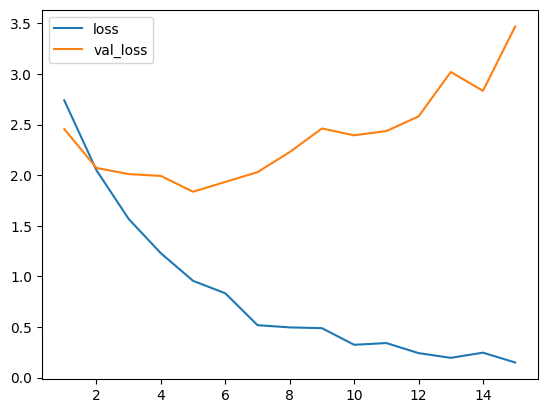

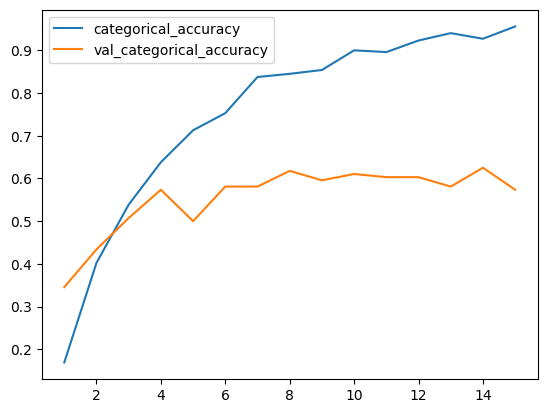

In [72]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [73]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 29ms/step - loss: 2.0117 - categorical_accuracy: 0.5364
Acurácia em dados de teste: 53.6424%


#### Dropout 40%

In [257]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 conv2d_101 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 conv2d_102 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 conv2d_103 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 conv2d_104 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                     

In [258]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 7s 171ms/step - loss: 4.7627 - categorical_accuracy: 0.0575 - val_loss: 2.9710 - val_categorical_accuracy: 0.0662
Epoch 2/100
39/39 [==============================] - 7s 173ms/step - loss: 2.8146 - categorical_accuracy: 0.1568 - val_loss: 3.0500 - val_categorical_accuracy: 0.1029
Epoch 3/100
39/39 [==============================] - 6s 165ms/step - loss: 2.5176 - categorical_accuracy: 0.2627 - val_loss: 2.5224 - val_categorical_accuracy: 0.3162
Epoch 4/100
39/39 [==============================] - 6s 163ms/step - loss: 2.0460 - categorical_accuracy: 0.4048 - val_loss: 2.1740 - val_categorical_accuracy: 0.3971
Epoch 5/100
39/39 [==============================] - 7s 168ms/step - loss: 1.5329 - categorical_accuracy: 0.5616 - val_loss: 2.0683 - val_categorical_accuracy: 0.5147
Epoch 6/100
39/39 [==============================] - 7s 170ms/step - loss: 1.2546 - categorical_accuracy: 0.6453 - val_loss: 1.8967 - val_categorical_accuracy: 0.544

Best Validation Loss: 1.8967
Best Validation Accuracy: 59.5588%


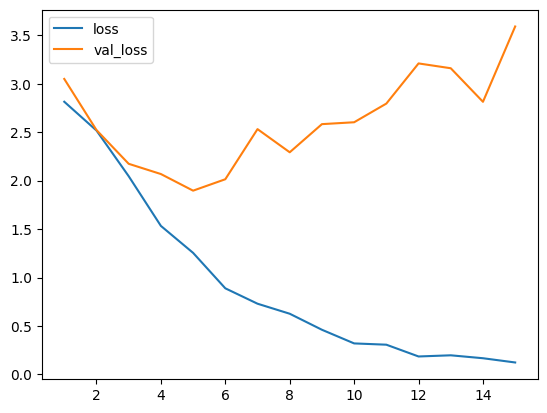

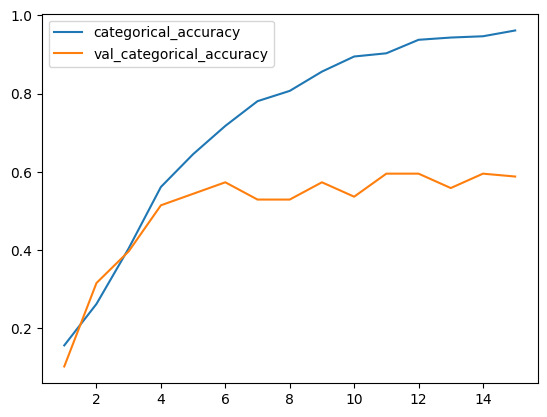

In [259]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [260]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 33ms/step - loss: 1.7889 - categorical_accuracy: 0.5629
Acurácia em dados de teste: 56.2914%


#### Dropout 50%

In [253]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_95 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_96 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_97 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_98 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_99 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                     

In [254]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 7s 170ms/step - loss: 6.2944 - categorical_accuracy: 0.0493 - val_loss: 2.9787 - val_categorical_accuracy: 0.0956
Epoch 2/100
39/39 [==============================] - 7s 168ms/step - loss: 2.9840 - categorical_accuracy: 0.0739 - val_loss: 2.9694 - val_categorical_accuracy: 0.1103
Epoch 3/100
39/39 [==============================] - 7s 174ms/step - loss: 2.8834 - categorical_accuracy: 0.1305 - val_loss: 2.7881 - val_categorical_accuracy: 0.1765
Epoch 4/100
39/39 [==============================] - 7s 169ms/step - loss: 2.5478 - categorical_accuracy: 0.2488 - val_loss: 2.6635 - val_categorical_accuracy: 0.1912
Epoch 5/100
39/39 [==============================] - 7s 188ms/step - loss: 2.1882 - categorical_accuracy: 0.3637 - val_loss: 2.4093 - val_categorical_accuracy: 0.3235
Epoch 6/100
39/39 [==============================] - 7s 178ms/step - loss: 1.7755 - categorical_accuracy: 0.4811 - val_loss: 2.3458 - val_categorical_accuracy: 0.411

Best Validation Loss: 2.1560
Best Validation Accuracy: 63.9706%


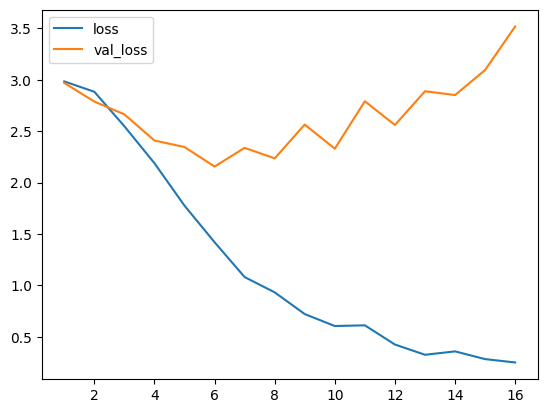

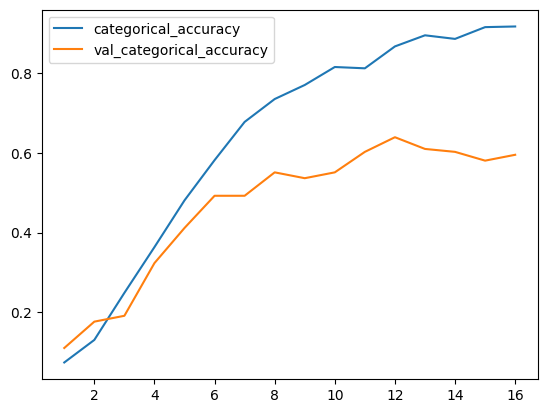

In [255]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [256]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 26ms/step - loss: 1.9300 - categorical_accuracy: 0.5033
Acurácia em dados de teste: 50.3311%


#### Dropout 60%

In [249]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.6),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_91 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_92 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_93 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_94 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                     

In [250]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 7s 170ms/step - loss: 4.8749 - categorical_accuracy: 0.0509 - val_loss: 2.9754 - val_categorical_accuracy: 0.1176
Epoch 2/100
39/39 [==============================] - 7s 169ms/step - loss: 2.9239 - categorical_accuracy: 0.1051 - val_loss: 2.8097 - val_categorical_accuracy: 0.1912
Epoch 3/100
39/39 [==============================] - 7s 172ms/step - loss: 2.6359 - categorical_accuracy: 0.2282 - val_loss: 2.5832 - val_categorical_accuracy: 0.2794
Epoch 4/100
39/39 [==============================] - 6s 166ms/step - loss: 2.3924 - categorical_accuracy: 0.2898 - val_loss: 2.3107 - val_categorical_accuracy: 0.3603
Epoch 5/100
39/39 [==============================] - 7s 168ms/step - loss: 2.0343 - categorical_accuracy: 0.3966 - val_loss: 1.9123 - val_categorical_accuracy: 0.5074
Epoch 6/100
39/39 [==============================] - 6s 165ms/step - loss: 1.6529 - categorical_accuracy: 0.4967 - val_loss: 2.0692 - val_categorical_accuracy: 0.500

Best Validation Loss: 1.8787
Best Validation Accuracy: 63.2353%


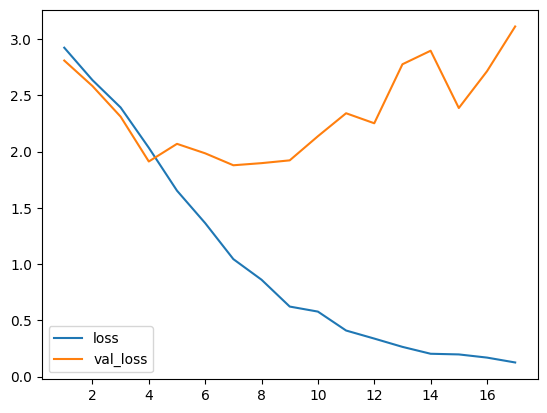

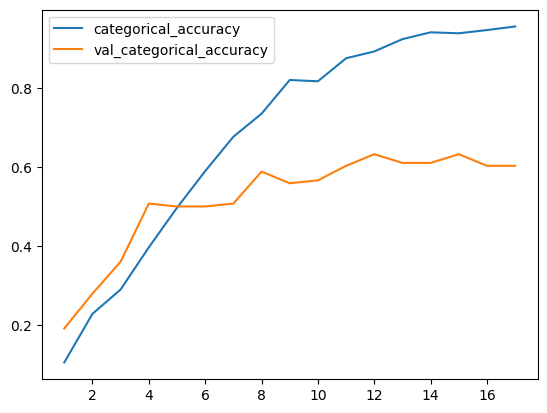

In [251]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [252]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 27ms/step - loss: 1.8512 - categorical_accuracy: 0.5563
Acurácia em dados de teste: 55.6291%


### Resultados:
    Sem Dropout - 56.9536%
    0.1 Dropout - 33.1126%
    0.2 Dropout - 58.9404% 
    0.3 Dropout - 53.6424%
    0.4 Dropout - 59.5588%
    0.5 Dropout - 50.3311%
    0.6 Dropout - 55.6291%

## Escolha Dropout: 40%

# Aplicando FineTunning com EfficientNetB3

## Modelo Utilizado para FineTunning

In [217]:
import tensorflow.keras.applications as apps
from tensorflow import keras
from tensorflow.keras import layers

modelBase = apps.EfficientNetB3(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
modelBase = Model(inputs=modelBase.input, outputs=modelBase.get_layer(index=-1).output)
modelBase.trainable = False

In [218]:
print("Model output", modelBase.output.shape)

Model output (None, 2, 2, 1536)


In [219]:
print(type(X_data))

<class 'numpy.ndarray'>


In [220]:
preds = modelBase.predict(np.array(X_data)[0:5])

1/1 [==============================] - 1s 1s/step


In [221]:
print("prediction shape", np.array(preds[0]).shape)

prediction shape (2, 2, 1536)


In [222]:
Predshape = np.array(preds[0]).reshape(-1).shape[0]

In [223]:
# Extração de features
print("Feature extraction ...")
predictionTrain = np.array(modelBase.predict(X_image_train))
featuresTrain = np.reshape(predictionTrain, (predictionTrain.shape[0], Predshape))
predictionVal = np.array(modelBase.predict(X_image_val))
featuresVal = np.reshape(predictionVal, (predictionVal.shape[0], Predshape))
predictionTest = np.array(modelBase.predict(X_image_test))
featuresTest = np.reshape(predictionTest, (predictionTest.shape[0], Predshape))

print('\tFeatures data shape: ', featuresTrain.shape)

Feature extraction ...
5/5 [==============================] - 0s 83ms/step
	Features data shape:  (1218, 6144)


In [224]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train = pca.fit_transform(featuresTrain)
X_val = pca.transform(featuresVal)
X_test = pca.transform(featuresTest)

print('X_train shape: ', X_train.shape)

X_train shape:  (1218, 360)


## Rede Classificadora

In [241]:
# Creating the Sequential Model
model = keras.Sequential([
    # Fully-connected layer
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

In [242]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 3.5708 - categorical_accuracy: 0.0903 - val_loss: 3.1151 - val_categorical_accuracy: 0.1324
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 2.7562 - categorical_accuracy: 0.2085 - val_loss: 2.6235 - val_categorical_accuracy: 0.2426
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 2.1655 - categorical_accuracy: 0.3834 - val_loss: 2.2812 - val_categorical_accuracy: 0.3676
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 1.7355 - categorical_accuracy: 0.5468 - val_loss: 2.0512 - val_categorical_accuracy: 0.4559
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 1.4266 - categorical_accuracy: 0.6683 - val_loss: 1.8773 - val_categorical_accuracy: 0.4779
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 1.1989 - categorical_accuracy: 0.7512 - val_loss: 1.7589 - val_categorical_accuracy: 0.5000
Epoch 7/10

Best Validation Loss: 1.3110
Best Validation Accuracy: 67.6471%


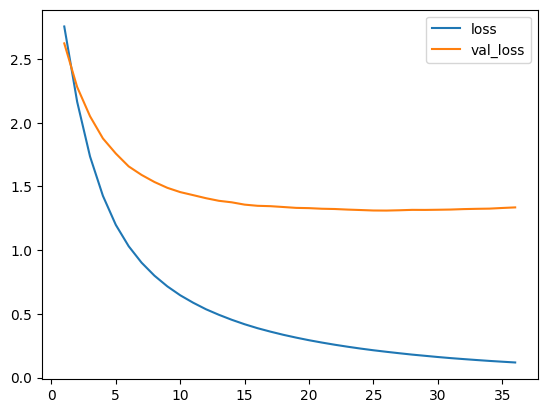

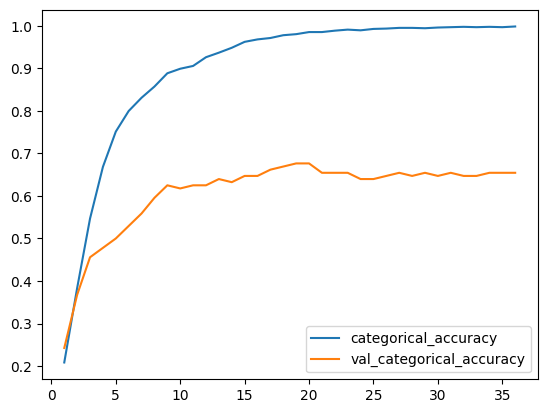

In [243]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [244]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 1ms/step - loss: 1.3668 - categorical_accuracy: 0.6159
Acurácia em dados de teste: 61.5894%


### Resultados:
    From Scratch: loss = 1.7889; Acurácia = 56.2914%
    FineTunning: loss = 1.3668; Acurácia = 61.5894%

## Escolha: FineTunning (EfficientNetB3)

### Testando datasets

In [181]:
def load_images_from_folder_matplot(folder):
    images = []
    for filename in os.listdir(folder):
        img = plt.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [182]:
letras = os.listdir("/media/emanueloliveira/Dados/SCC0910ComputerVision/Dataset/test/")

In [183]:
print(letras)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W']


In [200]:
imagesTest = []

for img in load_images_from_folder_matplot("/media/emanueloliveira/Dados/SCC0910ComputerVision/Brazilian-Sign-Language-Alphabet-Dataset/A/"):
    imagesTest.append(img)

In [201]:
print(imagesTest[0].shape)
print(X_train.shape)

(200, 200, 3)
(1218, 360)


In [202]:
cont = 0
for image in imagesTest:
    imagesTest[cont] = cv.resize(image, [64, 64])
    cont += 1 

In [203]:
print(imagesTest[0].shape)

(64, 64, 3)


In [204]:
imagesTest = np.asarray(imagesTest)

In [205]:
print(imagesTest.shape)

(540, 64, 64, 3)


In [206]:
predtest = np.array(modelBase.predict(imagesTest))

17/17 [==============================] - 1s 78ms/step


In [207]:
featuresTest = np.reshape(predtest, (predtest.shape[0], Predshape))
featuresTest = pca.transform(featuresTest)

In [208]:
print(featuresTest.shape)

(540, 360)


In [209]:
predicoes = model.predict(featuresTest)
argmaxPred = [np.argmax(i) for i in predicoes]

17/17 [==============================] - 0s 716us/step


In [210]:
print(predicoes[0])

[4.0854099e-01 2.0910345e-04 2.2019206e-03 3.7982026e-03 4.5593169e-01
 1.0066020e-03 1.9649982e-03 2.2325097e-02 4.8717097e-04 1.5665315e-02
 1.8423070e-04 1.7315333e-03 6.3784752e-04 1.0172992e-04 3.0338666e-03
 7.1599685e-02 8.2163475e-03 5.9657398e-04 9.5918088e-04 8.0782990e-04]


In [211]:
print(letras)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W']


In [212]:
predletra = []
for pred in argmaxPred:
    predletra.append(letras[pred])

In [213]:
print(len(predletra))

540


In [214]:
qtdAs = 0
for l in predletra:
    if l == 'A':
        qtdAs+=1
print(f"porcentagem de acerto: {round(qtdAs*100/540, 2)}%")

porcentagem de acerto: 25.19%


In [215]:
print(predletra)

['E', 'E', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'G', 'W', 'Q', 'W', 'W', 'W', 'W', 'W', 'W', 'A', 'W', 'W', 'W', 'W', 'W', 'W', 'C', 'W', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'M', 'A', 'M', 'M', 'M', 'A', 'M', 'M', 'M', 'M', 'A', 'A', 'A', 'A', 'A', 'A', 'M', 'M', 'M', 'M', 'M', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'M', 'M', 'M', 'M', 'M', 'A', 'M', 'M', 'G', 'G', 'G', 'G', 'G', 'G', 'E', 'E', 'A', 'M', 'A', 'A', 'S', 'E', 'A', 'A', 'A', 'G', 'A', 'M', 'M', 'A', 'A', 'A', 'Q', 'S', 'S', 'E', 'M', 'E', 'Q', 'O', 'C', 'E', 'E', 'M', 'W', 'G', 'W', 'W', 'W', 'M', 'Q', 'A', 'Q', 'M', 'W', 'M', 'M', 'M', 'M', 'M', 'S', 'A', 'S', 'S', 'S', 'S', 'S', 'E', 'S', 'E', 'E', 'E', 'A', 'A', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'A', 'E', 'E', 'E', 'E', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'M', 'A', 'A', 'A', 'A', 'A', 'M', 'M', 'M', 'M',

In [216]:
imgtest = X_data[1]
print(imgtest.shape)

(64, 64, 3)


In [120]:
features = modelBase.predict(imgtest.reshape(1, 64, 64, 3))
print(features.shape)

1/1 [==============================] - 0s 28ms/step
(1, 2, 2, 1536)


In [121]:
features = np.reshape(features, (features.shape[0], Predshape))
features = pca.transform(features)

In [122]:
print(features.shape)

(1, 200)


In [123]:
pred = model.predict(features.reshape(1, -1))

1/1 [==============================] - 0s 15ms/step


In [124]:
print(letras[np.argmax(pred)])

A


In [118]:
cv.imshow("image", X_data[1])

cv.waitKey(0)

cv.destroyAllWindows()

In [59]:
print(imagesTest.shape)

(540, 64, 64, 3)
